<a href="https://colab.research.google.com/github/Domdoug/DataScience-Classes/blob/master/Curso_GANs_IA_Expert_Academy_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN - Wasserstein GAN



## Importação das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.8.2'

## Carregamento e pré-processamento da base de dados

In [ ]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_treinamento.shape, y_treinamento.shape

((60000, 28, 28), (60000,))

In [ ]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_treinamento.shape

(60000, 28, 28, 1)

In [ ]:
X_treinamento = (X_treinamento - 127.5) / 127.5 

In [ ]:
buffer_size = y_treinamento.shape[0] #60000
batch_size = 256

X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

## Construção do Gerador

Usaremos a mesma arquitetura do gerador que usamos na implementação do DCGAN

In [ ]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))

  network.summary()

  return network

In [ ]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [ ]:
ruido = tf.random.normal([1, 100])
print(ruido)

tf.Tensor(
[[ 1.9625596   1.6812588  -0.21477701  0.4239084  -0.91508824  0.0650948
  -1.4520186  -0.6867194  -0.19525877 -0.21753582  1.3299505   0.01279503
  -0.79720896 -0.65051603  2.2139678  -1.9118332   0.23207462  1.4944967
   0.18082091  0.5909774   0.5792052  -0.35287702  1.1532729  -0.94703496
  -0.9326893   0.73315054  0.45293537  1.8023932  -1.3172374   0.3636049
   0.09637866 -0.5318943  -0.20543282 -1.4388309  -0.6989299  -0.27693078
  -1.3304008   0.6727863  -0.76151687  1.0212604   0.8333947   1.2827048
  -0.29250056 -0.8368631  -1.266261    0.82335615  0.7060485   0.8208642
  -0.3076467   0.5829208  -0.6351451  -0.4338133   0.9430694  -0.04380821
  -0.4794868  -0.2886563  -0.6847391  -1.1768624   0.12752579  0.20514442
   0.03409991  0.25235927  0.05554954  0.7329567   0.94034886 -1.4393603
   0.3396607   1.7378354  -0.15576495  0.45811492 -1.3769466   1.1220194
   0.38058758  0.20171186 -1.3312421  -0.43439907 -0.43416005 -0.6282967
   1.2415713  -0.59271413 -1.231129

(1, 28, 28, 1)


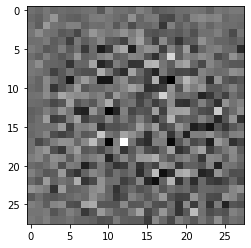

In [ ]:
imagem_gerada = gerador(ruido, training = False)
print(imagem_gerada.shape)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

## Construção do Discriminador

Obs: No contexto de WGAN, o discriminador é chamado também de Crítico 

In [ ]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [ ]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
resultado = discriminador(imagem_gerada)
print(resultado)

tf.Tensor([[-0.0022878]], shape=(1, 1), dtype=float32)



## Funções de perda **Wasserstein Loss**

A perda (*loss*) é a diferença entre o valor esperado da saída do discriminador para imagens autênticas e o valor esperado do discriminador para imagens falsas que foram geradas. 

* O objetivo do discriminador é maximizar essa diferença, enquanto que o objetivo do gerador é minimizar. 

Então, podemos criar o loss/perda para podermos monitorar os estágios de treinamento. 

In [ ]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.95])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.68333334>

In [ ]:
def loss_gerador(fake_saida):
  g_loss = -1. * tf.math.reduce_mean(fake_saida)
  return g_loss

In [ ]:
def loss_discriminador(real_saida, fake_saida, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_saida) - tf.math.reduce_mean(real_saida) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Parâmetros beta: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 Para usar a perda de Wasserstein, nosso discriminador precisa ser **1-L** [(1-Lipschitz) contínuo](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt), ou seja, a norma do gradiente deve ser no máximo 1 em cada ponto.
 
Para impor a continuidade de 1-L usaremos o conceito de **Gradient Penalty**.

Essa variação foi apelidada de **WGAN-GP** (devido ao uso do **G**radient **P**enalty)

(Mais sobre Gradient Penalty [nesse artigo](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Para calcular o gradient penalty faremos o seguinte:
1. Calcular uma imagem interpolada da imagem real e fake (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calcular o gradiente da saída do discriminador em relação à imagem interpolada. Depois disso, calcular a norma do gradiente.
3. Por fim, a penalidade é calculada como uma média do quadrado de (norma - 1), pois queremos que a norma seja próxima de um.

Para trabalhar com algumas das operações envolvendo gradiente usamos o  [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  imgs_interpoladas = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(imgs_interpoladas)
    scores = discriminador(imgs_interpoladas)
  gradient = tape.gradient(scores, imgs_interpoladas)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [ ]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(generator_optimizer = gerador_optimizer,
                                 discrimanator_optimizer = discriminador_optimizer,
                                 generator=gerador,
                                 discriminator=discriminador)

## Treinamento da GAN e visualização dos resultados

In [ ]:
epochs = 30
noise_dim = 100
num_amostras = 16
seed = tf.random.normal([num_amostras, noise_dim])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.8091474 ,  0.96704984,  0.97330505, ..., -0.7233357 ,
         2.2699888 ,  1.2576685 ],
       [-1.2051823 ,  0.26957673, -1.0970652 , ...,  1.5108677 ,
        -0.8701974 , -0.48953816],
       [-0.21295106,  1.3834059 , -1.2439843 , ...,  0.79665166,
        -0.89383936,  1.6243883 ],
       ...,
       [-1.6406949 , -1.8932245 ,  0.7598515 , ..., -1.7375468 ,
        -0.640404  ,  0.21986923],
       [-0.20306939, -0.08445342, -0.52400553, ..., -1.3959503 ,
         0.14024308,  1.7102164 ],
       [-0.7526116 ,  0.8061582 ,  1.6270655 , ..., -1.7403052 ,
         0.11543556,  1.1507468 ]], dtype=float32)>

In [ ]:
def etapa_treinamento(imgs):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminador_etapas_extras = 3
  for i in range(discriminador_etapas_extras):
    with tf.GradientTape() as d_tape:
      imgs_geradas = gerador(noise, training = True)
      real_saida = discriminador(imgs, training = True)
      fake_saida = discriminador(imgs_geradas, training=True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(imgs, imgs_geradas, epsilon)

      d_loss = loss_discriminador(real_saida, fake_saida, gp)
    
    discriminador_gradients = d_tape.gradient(d_loss, discriminador.trainable_variables)
    discriminador_optimizer.apply_gradients(zip(discriminador_gradients, discriminador.trainable_variables))

  with tf.GradientTape() as g_tape:
    imgs_geradas = gerador(noise, training = True)
    fake_saida = discriminador(imgs_geradas, training = True)
    g_loss = loss_gerador(fake_saida)
  gerador_gradients = g_tape.gradient(g_loss, gerador.trainable_variables)
  gerador_optimizer.apply_gradients(zip(gerador_gradients, gerador.trainable_variables))

Sobre logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [ ]:
def gerar_e_salvar_imgs(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def treinar(dataset, epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        etapa_treinamento(img_batch)
    
    #display.clear_output(wait = True)
    gerar_e_salvar_imgs(gerador, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefixo)
    print('Tempo para processar época {} foi de {} segundos'.format(epoch + 1, time.time() - inicio))

  #display.clear_output(wait = True)
  gerar_e_salvar_imgs(gerador, epochs, seed)
  gerador.save('gerador.h5')

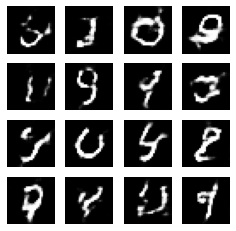

Tempo para processar época 1 foi de 74.92675757408142 segundos


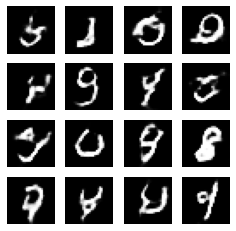

Tempo para processar época 2 foi de 74.56495428085327 segundos


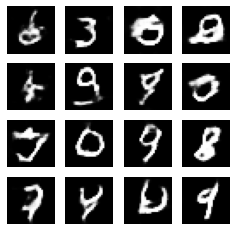

Tempo para processar época 3 foi de 74.394376039505 segundos


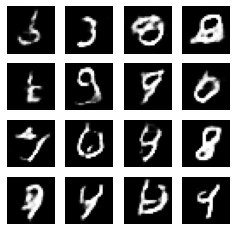

Tempo para processar época 4 foi de 74.19785404205322 segundos


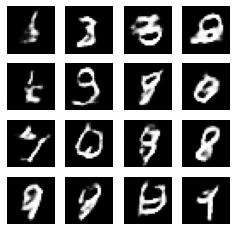

Tempo para processar época 5 foi de 74.24701595306396 segundos


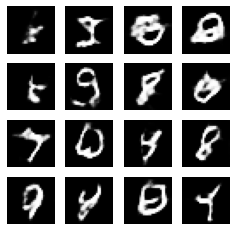

Tempo para processar época 6 foi de 74.90910959243774 segundos


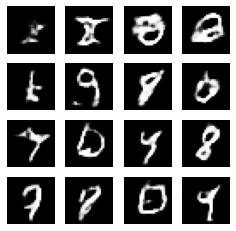

Tempo para processar época 7 foi de 74.43885612487793 segundos


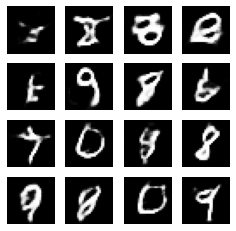

Tempo para processar época 8 foi de 74.04735827445984 segundos


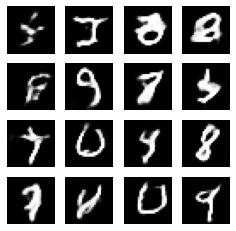

Tempo para processar época 9 foi de 74.09681749343872 segundos


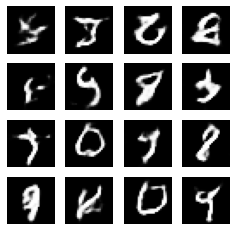

Tempo para processar época 10 foi de 74.53199458122253 segundos


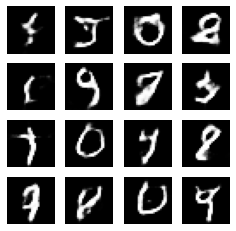

Tempo para processar época 11 foi de 74.14453721046448 segundos


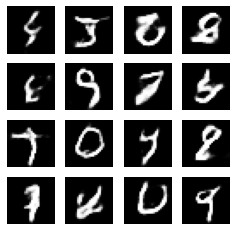

Tempo para processar época 12 foi de 74.02172446250916 segundos


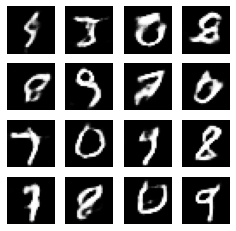

Tempo para processar época 13 foi de 74.34520077705383 segundos


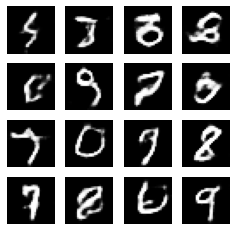

Tempo para processar época 14 foi de 74.62878131866455 segundos


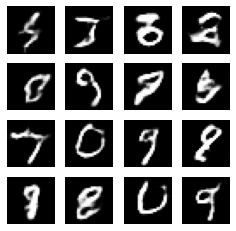

Tempo para processar época 15 foi de 74.50321578979492 segundos


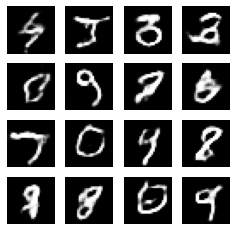

Tempo para processar época 16 foi de 74.31762742996216 segundos


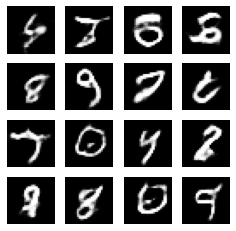

Tempo para processar época 17 foi de 74.2428195476532 segundos


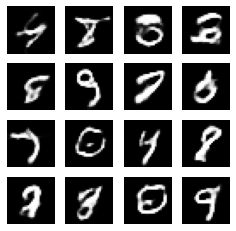

Tempo para processar época 18 foi de 74.32610130310059 segundos


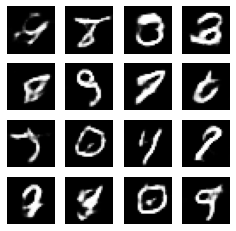

Tempo para processar época 19 foi de 74.41968655586243 segundos


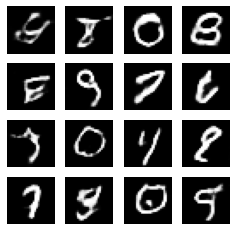

Tempo para processar época 20 foi de 74.34761571884155 segundos


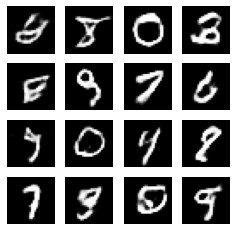

Tempo para processar época 21 foi de 74.31284284591675 segundos


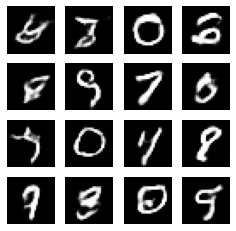

Tempo para processar época 22 foi de 74.17274475097656 segundos


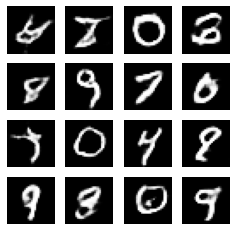

Tempo para processar época 23 foi de 78.25000095367432 segundos


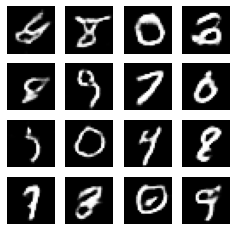

Tempo para processar época 24 foi de 82.67926025390625 segundos


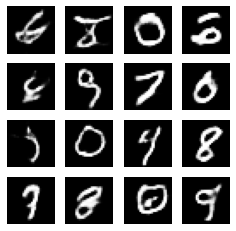

Tempo para processar época 25 foi de 81.92187833786011 segundos


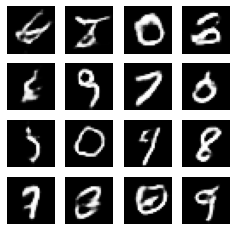

Tempo para processar época 26 foi de 75.19136667251587 segundos


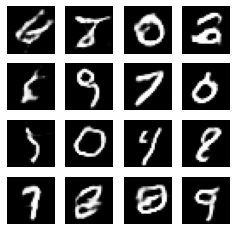

Tempo para processar época 27 foi de 74.40358138084412 segundos


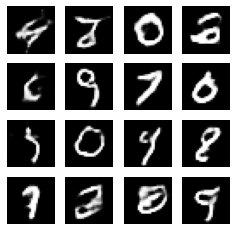

Tempo para processar época 28 foi de 74.51504302024841 segundos


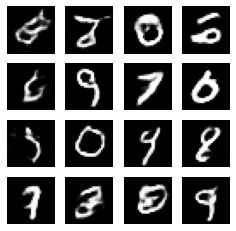

Tempo para processar época 29 foi de 75.06302165985107 segundos


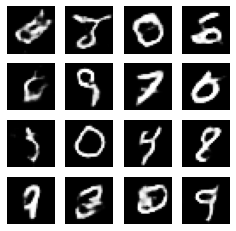

Tempo para processar época 30 foi de 74.63742470741272 segundos


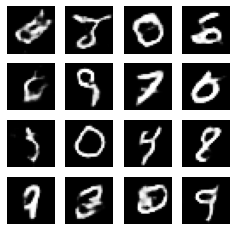

In [ ]:
treinar(X_treinamento, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

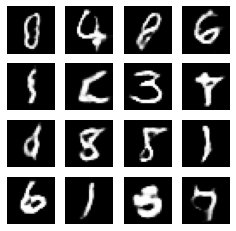

In [ ]:
seed_input = tf.random.normal([num_amostras, noise_dim])
preds = gerador(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> Mais implementações:

* https://github.com/robbiebarrat/art-DCGAN (baseado em DCGAN)
* https://github.com/tdrussell/IllustrationGAN (baseado em DCGAN)
* https://github.com/viuts/wgan-animefaces (baseado em WGAN)